In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
import numpy as np

import matplotlib.pyplot as plt
import random

In [2]:
def plt_display(image, title):
    fig = plt.figure()
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)
    a.set_title(title)

## Load Data

### Load Zurich dataset as source dataset
- https://docs.google.com/forms/d/e/1FAIpQLSdH6Pqdlu0pk2vGZlazqoRYwWsxN3nsLFwYY6Zc5-RUjw3SdQ/viewform

In [3]:
from datasets.huavei import HuaveiLoader

base_dir = "/home/gosha20777/Zurich-RAW-to-DSLR-Dataset"
train_input_dir = os.path.join(base_dir, "train/huawei_raw")
train_target_dir = os.path.join(base_dir, "train/canon")
test_input_dir = os.path.join(base_dir, "test/huawei_raw")
test_target_dir = os.path.join(base_dir, "test/canon")
img_size = (224, 224)
dlsr_scale = 2
input_channels = 4
output_channels = 3
batch_size = 8

input_img_paths = sorted(
    [
        os.path.join(train_input_dir, fname)
        for fname in os.listdir(train_input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(train_target_dir, fname)
        for fname in os.listdir(train_target_dir)
        if fname.endswith(".jpg")
    ]
)

test_input_img_paths = sorted(
    [
        os.path.join(test_input_dir, fname)
        for fname in os.listdir(test_input_dir)
        if fname.endswith(".png")
    ]
)
test_target_img_paths = sorted(
    [
        os.path.join(test_target_dir, fname)
        for fname in os.listdir(test_target_dir)
        if fname.endswith(".jpg")
    ]
)


for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(os.path.basename(input_path), "|", os.path.basename(target_path))
    
val_samples = 4000
random.Random(42).shuffle(input_img_paths)
random.Random(42).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = HuaveiLoader(
    batch_size, img_size, dlsr_scale, train_input_img_paths, train_target_img_paths
)
val_gen = HuaveiLoader(
    batch_size, img_size, dlsr_scale, val_input_img_paths, val_target_img_paths
)
test_gen = HuaveiLoader(
    batch_size, img_size, dlsr_scale, test_input_img_paths, test_target_img_paths
)

print("Number of samples:", len(input_img_paths))
print("Number train batches:", len(train_gen))
print("Number val batches:", len(val_gen))
print("Number test batches:", len(test_gen))

0.png | 0.jpg
1.png | 1.jpg
10.png | 10.jpg
100.png | 100.jpg
1000.png | 1000.jpg
10000.png | 10000.jpg
10001.png | 10001.jpg
10002.png | 10002.jpg
10003.png | 10003.jpg
10004.png | 10004.jpg
Number of samples: 46839
Number train batches: 5354
Number val batches: 500
Number test batches: 150


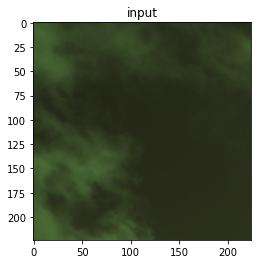

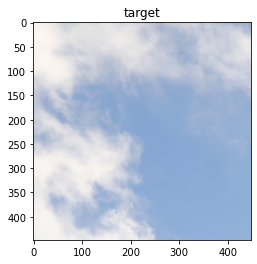

In [4]:
x, y = train_gen.__getitem__(0)
plt_display(x[3][:,:,0:3], 'input')
plt_display(y[3], 'target')

## Source Domain Network

In [5]:
from losses.losses import mssim, vgg_loss

def main_loss(y_true, y_pred):
    return tf.keras.losses.mean_absolute_error(y_true, y_pred) + \
        mssim(y_true, y_pred) + \
        vgg_loss(y_true, y_pred)

def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, 1.0)

def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, 1.0)

In [6]:
from models import encoder, unet, dann

s_encoder = encoder.get_model()
u_net = unet.get_model()
s_model = dann.SingleNet(
    encoder=s_encoder,
    u_net=u_net
)

### Train

In [7]:
s_model.compile(optimizer="adam", loss_fn=main_loss, metrics=[psnr, ssim])

epochs = 4

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir="logs/source_zurich")
]

history = s_model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks, workers=8)

Epoch 1/4
5354/5354 [==============================] - 2172s 401ms/step - psnr: 17.9708 - ssim: 0.7013 - source_loss: 0.9066 - val_psnr: 19.0385 - val_ssim: 0.7345 - val_source_loss: 0.6736
Epoch 2/4
5354/5354 [==============================] - 2145s 401ms/step - psnr: 19.1875 - ssim: 0.7270 - source_loss: 0.7999 - val_psnr: 19.6764 - val_ssim: 0.7284 - val_source_loss: 0.7012
Epoch 3/4
5354/5354 [==============================] - 2149s 401ms/step - psnr: 19.5476 - ssim: 0.7328 - source_loss: 0.7787 - val_psnr: 19.4851 - val_ssim: 0.7345 - val_source_loss: 0.6948
Epoch 4/4
5354/5354 [==============================] - 2139s 400ms/step - psnr: 19.6196 - ssim: 0.7340 - source_loss: 0.7701 - val_psnr: 19.5876 - val_ssim: 0.7337 - val_source_loss: 0.6712


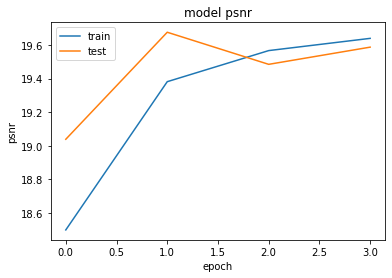

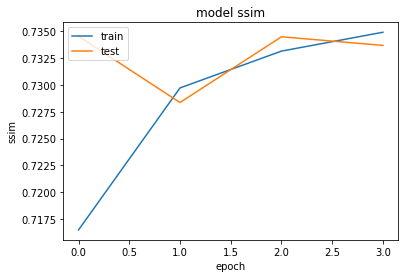

In [13]:
# summarize history for psnr
plt.plot(history.history['psnr'])
plt.plot(history.history['val_psnr'])
plt.title('model psnr')
plt.ylabel('psnr')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for ssim
plt.plot(history.history['ssim'])
plt.plot(history.history['val_ssim'])
plt.title('model ssim')
plt.ylabel('ssim')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Save

In [14]:
s_encoder.save('s_encoder_zurich.h5')
u_net.save('s_u_net_zurich.h5')

### Evaluate

In [15]:
print("Evaluate on test data")
psnr_val, ssim_val, _ = s_model.evaluate(test_gen)
print(f"psnr: {psnr_val}, ssim: {ssim_val}")

Evaluate on test data
150/150 [==============================] - 26s 171ms/step - psnr: 19.6198 - ssim: 0.7254 - source_loss: 0.8222
psnr: 19.619775772094727, ssim: 0.725426197052002
